# 1.3c: Telescope

This notebook zooms in on a specific region of the sky to examine local structure at small angular scales.

## The Question

The full sky maps (1.3a, 1.3b) show the global structure. But what happens when we zoom in to a small patch of sky? Can we resolve individual tokens? Do we see quantization effects at small angular separations?

To answer this, we'll:
1. Select a region of sky by latitude/longitude and angular diameter
2. Filter tokens to only those within the region
3. Plot them in a simple rectangular projection (longitude × latitude)
4. Compare float32 vs bfloat16 precision at this angular scale

## Coordinate System

We use the same PCA-based spherical coordinates as 1.3a and 1.3b. But instead of Mollweide or polar projections, we use a simple rectangular plot:

- **X-axis**: Longitude
- **Y-axis**: Latitude
- **Center**: User-specified (lat, lon) point
- **Extent**: ± angular_diameter / 2 in both directions

## Parameters

In [31]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"
# MODEL_NAME = "Qwen2.5-3B-Instruct"

# PCA basis selection (1-indexed)
# Negative values flip the direction (e.g., -1 = negative PC1)
NORTH_PC = 2      # North pole (+90° latitude)
MERIDIAN_PC = 1   # Prime meridian (0° longitude)
EQUINOX_PC = 3    # Equinox (+90° longitude)

# Telescope pointing
CENTER_LAT = -7.289       # Latitude of center (degrees)
CENTER_LON = 6.940        # Longitude of center (degrees)
ANGULAR_DIAMETER = 0.200  # Field of view (degrees)

# Visualization
POINT_SIZE = 5
POINT_ALPHA = 0.5
COLOR = 'steelblue'
FIGSIZE = (12, 10)
DPI = 200

# Density heatmap
ANGULAR_BIN_SIZE = 0.01   # Degrees per bin
DENSITY_SMOOTH = 0.5     # Gaussian smoothing sigma (None = no smoothing)
DENSITY_COLORMAP = 'hot'

## Imports

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from safetensors.torch import load_file
from pathlib import Path

## Load W

In [33]:
# Load W in bfloat16
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]

print(f"Loaded W from {tensor_path}")
print(f"  Shape: {W_bf16.shape}")
print(f"  Dtype: {W_bf16.dtype}")

# Convert to float32 for numerical precision
W = W_bf16.to(torch.float32)
print(f"  Converted to {W.dtype} for analysis")

N, d = W.shape
print(f"\nToken space: {N:,} tokens in {d:,} dimensions")

Loaded W from ../tensors/Qwen3-4B-Instruct-2507/W.safetensors
  Shape: torch.Size([151936, 2560])
  Dtype: torch.bfloat16
  Converted to torch.float32 for analysis

Token space: 151,936 tokens in 2,560 dimensions


## Compute PCA

In [34]:
print("Computing PCA...")

# Center the data
W_centered = W - W.mean(dim=0)

# Compute covariance matrix (d × d)
print("  Computing covariance matrix...")
cov = (W_centered.T @ W_centered) / N

# Eigendecomposition
print("  Computing eigendecomposition...")
eigenvalues, eigenvectors = torch.linalg.eigh(cov)

# Sort by descending eigenvalue (eigh returns ascending)
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print(f"\n✓ PCA computed")
print(f"  Top 3 eigenvalues:")
for i in range(3):
    var_explained = eigenvalues[i] / eigenvalues.sum() * 100
    print(f"    PC{i+1}: λ = {eigenvalues[i]:.6f} ({var_explained:.2f}% variance)")

Computing PCA...
  Computing covariance matrix...
  Computing eigendecomposition...

✓ PCA computed
  Top 3 eigenvalues:
    PC1: λ = 0.010487 (0.94% variance)
    PC2: λ = 0.003178 (0.28% variance)
    PC3: λ = 0.002791 (0.25% variance)


## Define Spherical Basis

In [35]:
def get_pc_vector(pcs, index):
    """Get PC vector by index (1-indexed), with sign flip for negative indices.
    
    Examples:
        1  -> PC1
        -1 -> -PC1 (flipped)
        2  -> PC2
        -3 -> -PC3 (flipped)
    """
    pc_num = abs(index) - 1  # Convert to 0-indexed
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector


# Extract basis vectors
north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print("Spherical coordinate basis:")
print(f"  North (+Z, north pole):    PC{NORTH_PC}")
print(f"  Meridian (+X, 0° lon):     PC{MERIDIAN_PC}")
print(f"  Equinox (+Y, 90° lon):     PC{EQUINOX_PC}")

Spherical coordinate basis:
  North (+Z, north pole):    PC2
  Meridian (+X, 0° lon):     PC1
  Equinox (+Y, 90° lon):     PC3


## Project to Spherical Coordinates

In [36]:
print("Projecting to spherical coordinates...\n")

# Project onto basis vectors
x = W @ meridian  # +X (prime meridian, 0° longitude)
y = W @ equinox   # +Y (equinox, 90° longitude)
z = W @ north     # +Z (north pole, +90° latitude)

# Compute radius
r = torch.sqrt(x**2 + y**2 + z**2)

# Spherical coordinates
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)

lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print("✓ Spherical coordinates computed")
print(f"  Full sky: {N:,} tokens")

Projecting to spherical coordinates...

✓ Spherical coordinates computed
  Full sky: 151,936 tokens


## Filter Tokens to Region

In [37]:
print(f"\nFiltering tokens to region...")
print(f"  Center: ({CENTER_LAT:.2f}°, {CENTER_LON:.2f}°)")
print(f"  Angular diameter: {ANGULAR_DIAMETER:.2f}°")
print()

# Define region bounds
half_width = ANGULAR_DIAMETER / 2
lat_min = CENTER_LAT - half_width
lat_max = CENTER_LAT + half_width
lon_min = CENTER_LON - half_width
lon_max = CENTER_LON + half_width

print(f"  Latitude range: [{lat_min:.2f}°, {lat_max:.2f}°]")
print(f"  Longitude range: [{lon_min:.2f}°, {lon_max:.2f}°]")
print()

# Filter tokens
mask = (
    (lat_deg >= lat_min) & (lat_deg <= lat_max) &
    (lon_deg >= lon_min) & (lon_deg <= lon_max)
)

# Apply filter
W_region = W[mask]
W_bf16_region = W_bf16[mask]
lat_region = lat_deg[mask]
lon_region = lon_deg[mask]
r_region = r[mask]

n_region = mask.sum().item()
print(f"✓ Filtered to {n_region:,} tokens ({n_region/N*100:.2f}% of total)")


Filtering tokens to region...
  Center: (-7.29°, 6.94°)
  Angular diameter: 0.20°

  Latitude range: [-7.39°, -7.19°]
  Longitude range: [6.84°, 7.04°]

✓ Filtered to 2,233 tokens (1.47% of total)


## Precision Comparison: Float32 vs Bfloat16 Cosines

In [38]:
print("\nComparing float32 vs bfloat16 precision...\n")

if n_region > 1:
    # Compute cosine similarities in float32
    W_norm_f32 = W_region / W_region.norm(dim=1, keepdim=True)
    cosines_f32 = W_norm_f32 @ W_norm_f32.T
    
    # Compute cosine similarities in bfloat16
    W_norm_bf16 = W_bf16_region / W_bf16_region.norm(dim=1, keepdim=True)
    cosines_bf16 = (W_norm_bf16 @ W_norm_bf16.T).to(torch.float32)
    
    # Extract upper triangle (exclude diagonal)
    triu_indices = torch.triu_indices(n_region, n_region, offset=1)
    cosines_f32_vals = cosines_f32[triu_indices[0], triu_indices[1]]
    cosines_bf16_vals = cosines_bf16[triu_indices[0], triu_indices[1]]
    
    # Compute differences
    cosine_diff = (cosines_f32_vals - cosines_bf16_vals).abs()
    
    print(f"Pairwise cosine similarities ({len(cosines_f32_vals):,} pairs):")
    print()
    print("Float32:")
    print(f"  Range: [{cosines_f32_vals.min():.8f}, {cosines_f32_vals.max():.8f}]")
    print(f"  Mean: {cosines_f32_vals.mean():.8f}")
    print()
    print("Bfloat16:")
    print(f"  Range: [{cosines_bf16_vals.min():.8f}, {cosines_bf16_vals.max():.8f}]")
    print(f"  Mean: {cosines_bf16_vals.mean():.8f}")
    print()
    print("Absolute difference (|f32 - bf16|):")
    print(f"  Max: {cosine_diff.max():.8f}")
    print(f"  Mean: {cosine_diff.mean():.8f}")
    print(f"  Median: {cosine_diff.median():.8f}")
    
    # Convert cosines to angular separation
    # cos(θ) ≈ 1 - θ²/2 for small θ, so θ ≈ sqrt(2(1-cos(θ)))
    # But more accurately: θ = arccos(cos(θ))
    angles_f32 = torch.rad2deg(torch.acos(torch.clamp(cosines_f32_vals, -1, 1)))
    angles_bf16 = torch.rad2deg(torch.acos(torch.clamp(cosines_bf16_vals, -1, 1)))
    angle_diff = (angles_f32 - angles_bf16).abs()
    
    print()
    print("Angular separations:")
    print(f"  Float32 range: [{angles_f32.min():.6f}°, {angles_f32.max():.6f}°]")
    print(f"  Bfloat16 range: [{angles_bf16.min():.6f}°, {angles_bf16.max():.6f}°]")
    print(f"  Max difference: {angle_diff.max():.6f}°")
else:
    print("Need at least 2 tokens in region to compute pairwise cosines.")


Comparing float32 vs bfloat16 precision...

Pairwise cosine similarities (2,492,028 pairs):

Float32:
  Range: [0.13591714, 1.00000358]
  Mean: 0.99882507

Bfloat16:
  Range: [0.13574219, 1.00000000]
  Mean: 0.99880028

Absolute difference (|f32 - bf16|):
  Max: 0.00644052
  Mean: 0.00003615
  Median: 0.00000215

Angular separations:
  Float32 range: [0.000000°, 82.188347°]
  Bfloat16 range: [0.000000°, 82.198456°]
  Max difference: 5.999499°


## Rectangular Scatter Plot


Creating rectangular scatter plot...



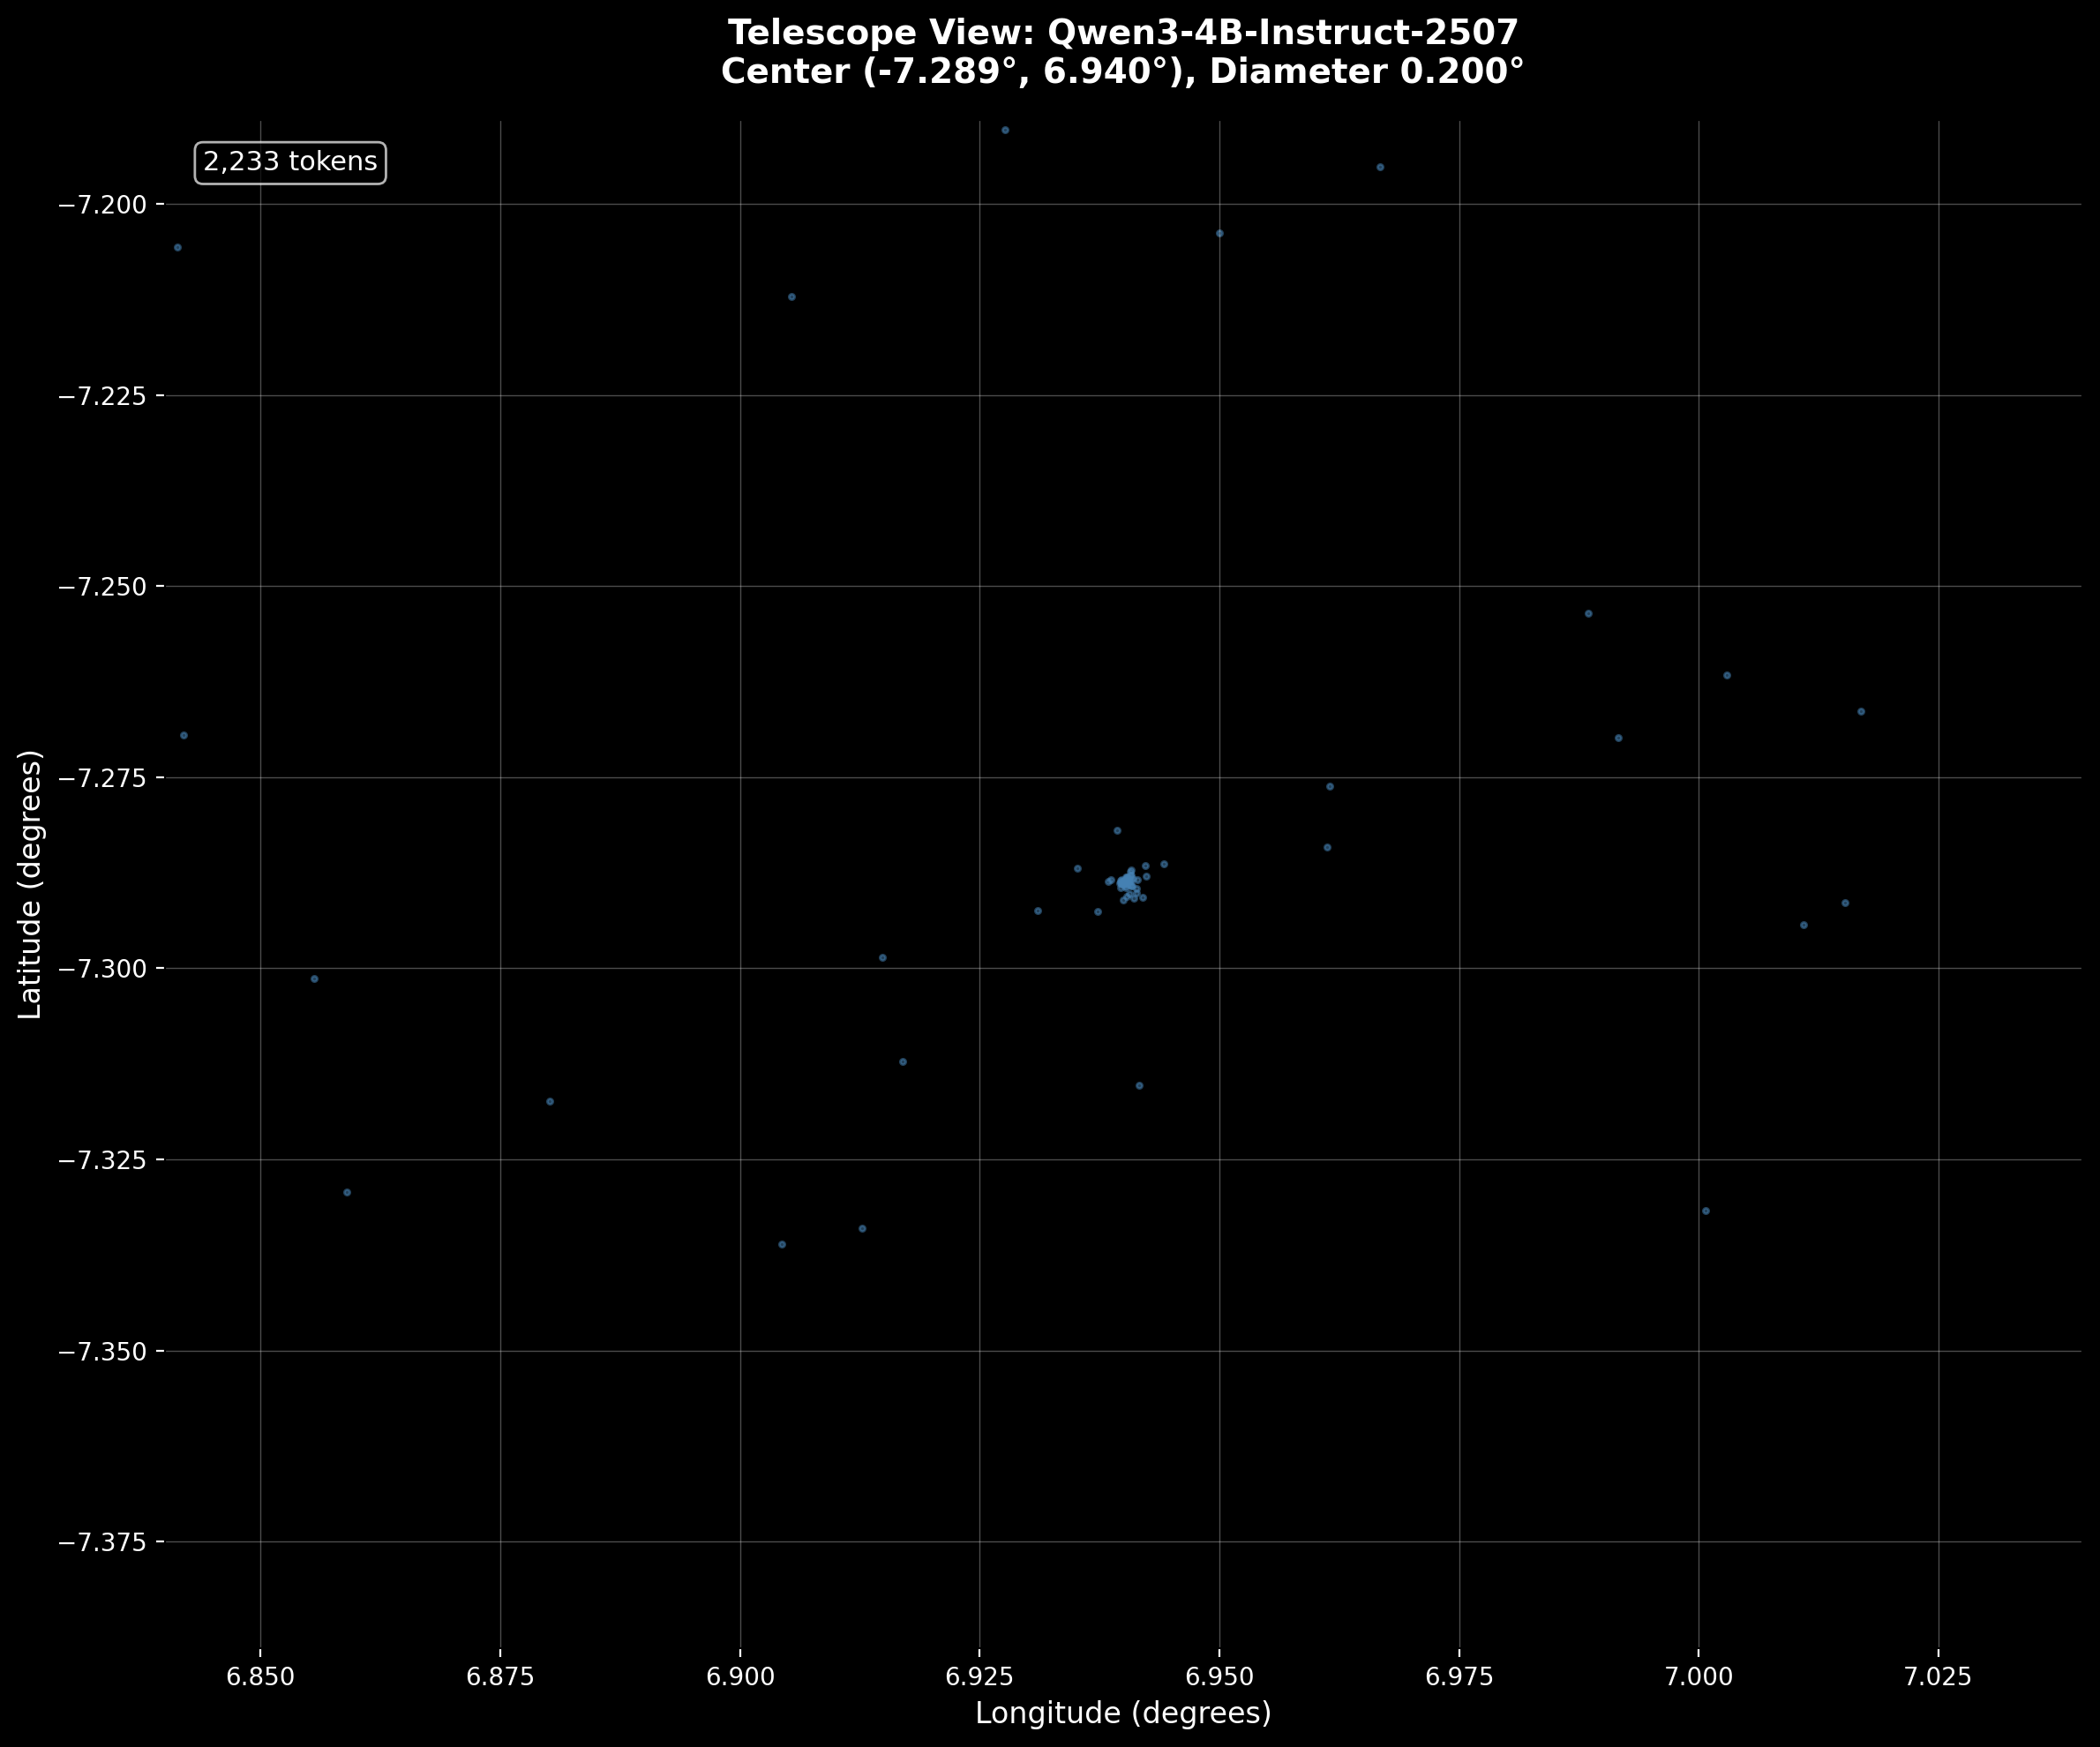

✓ Rectangular scatter plot complete


In [39]:
print("\nCreating rectangular scatter plot...\n")

# Convert to numpy
lat_plot = lat_region.numpy()
lon_plot = lon_region.numpy()

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Plot points
ax.scatter(lon_plot, lat_plot, s=POINT_SIZE, alpha=POINT_ALPHA, c=COLOR, rasterized=True)

# Formatting
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.set_xlabel('Longitude (degrees)', color='white', fontsize=12)
ax.set_ylabel('Latitude (degrees)', color='white', fontsize=12)
ax.set_title(f'Telescope View: {MODEL_NAME}\nCenter ({CENTER_LAT:.3f}°, {CENTER_LON:.3f}°), Diameter {ANGULAR_DIAMETER:.3f}°',
             color='white', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, color='white', linewidth=0.5)
ax.tick_params(colors='white')

# Add token count annotation
ax.text(0.02, 0.98, f'{n_region:,} tokens', 
        transform=ax.transAxes, fontsize=11, 
        verticalalignment='top', color='white',
        bbox=dict(boxstyle='round', facecolor='black', alpha=0.7, edgecolor='white'))

plt.tight_layout()
plt.show()

print("✓ Rectangular scatter plot complete")

## Rectangular Density Heatmap


Creating rectangular density heatmap...

Density grid: 20 × 20 bins
  Angular bin size: 0.01°

Applied Gaussian smoothing (σ = 0.5)
Density statistics:
  Max density: 1351.5 tokens per bin
  Mean density: 5.6 tokens per bin



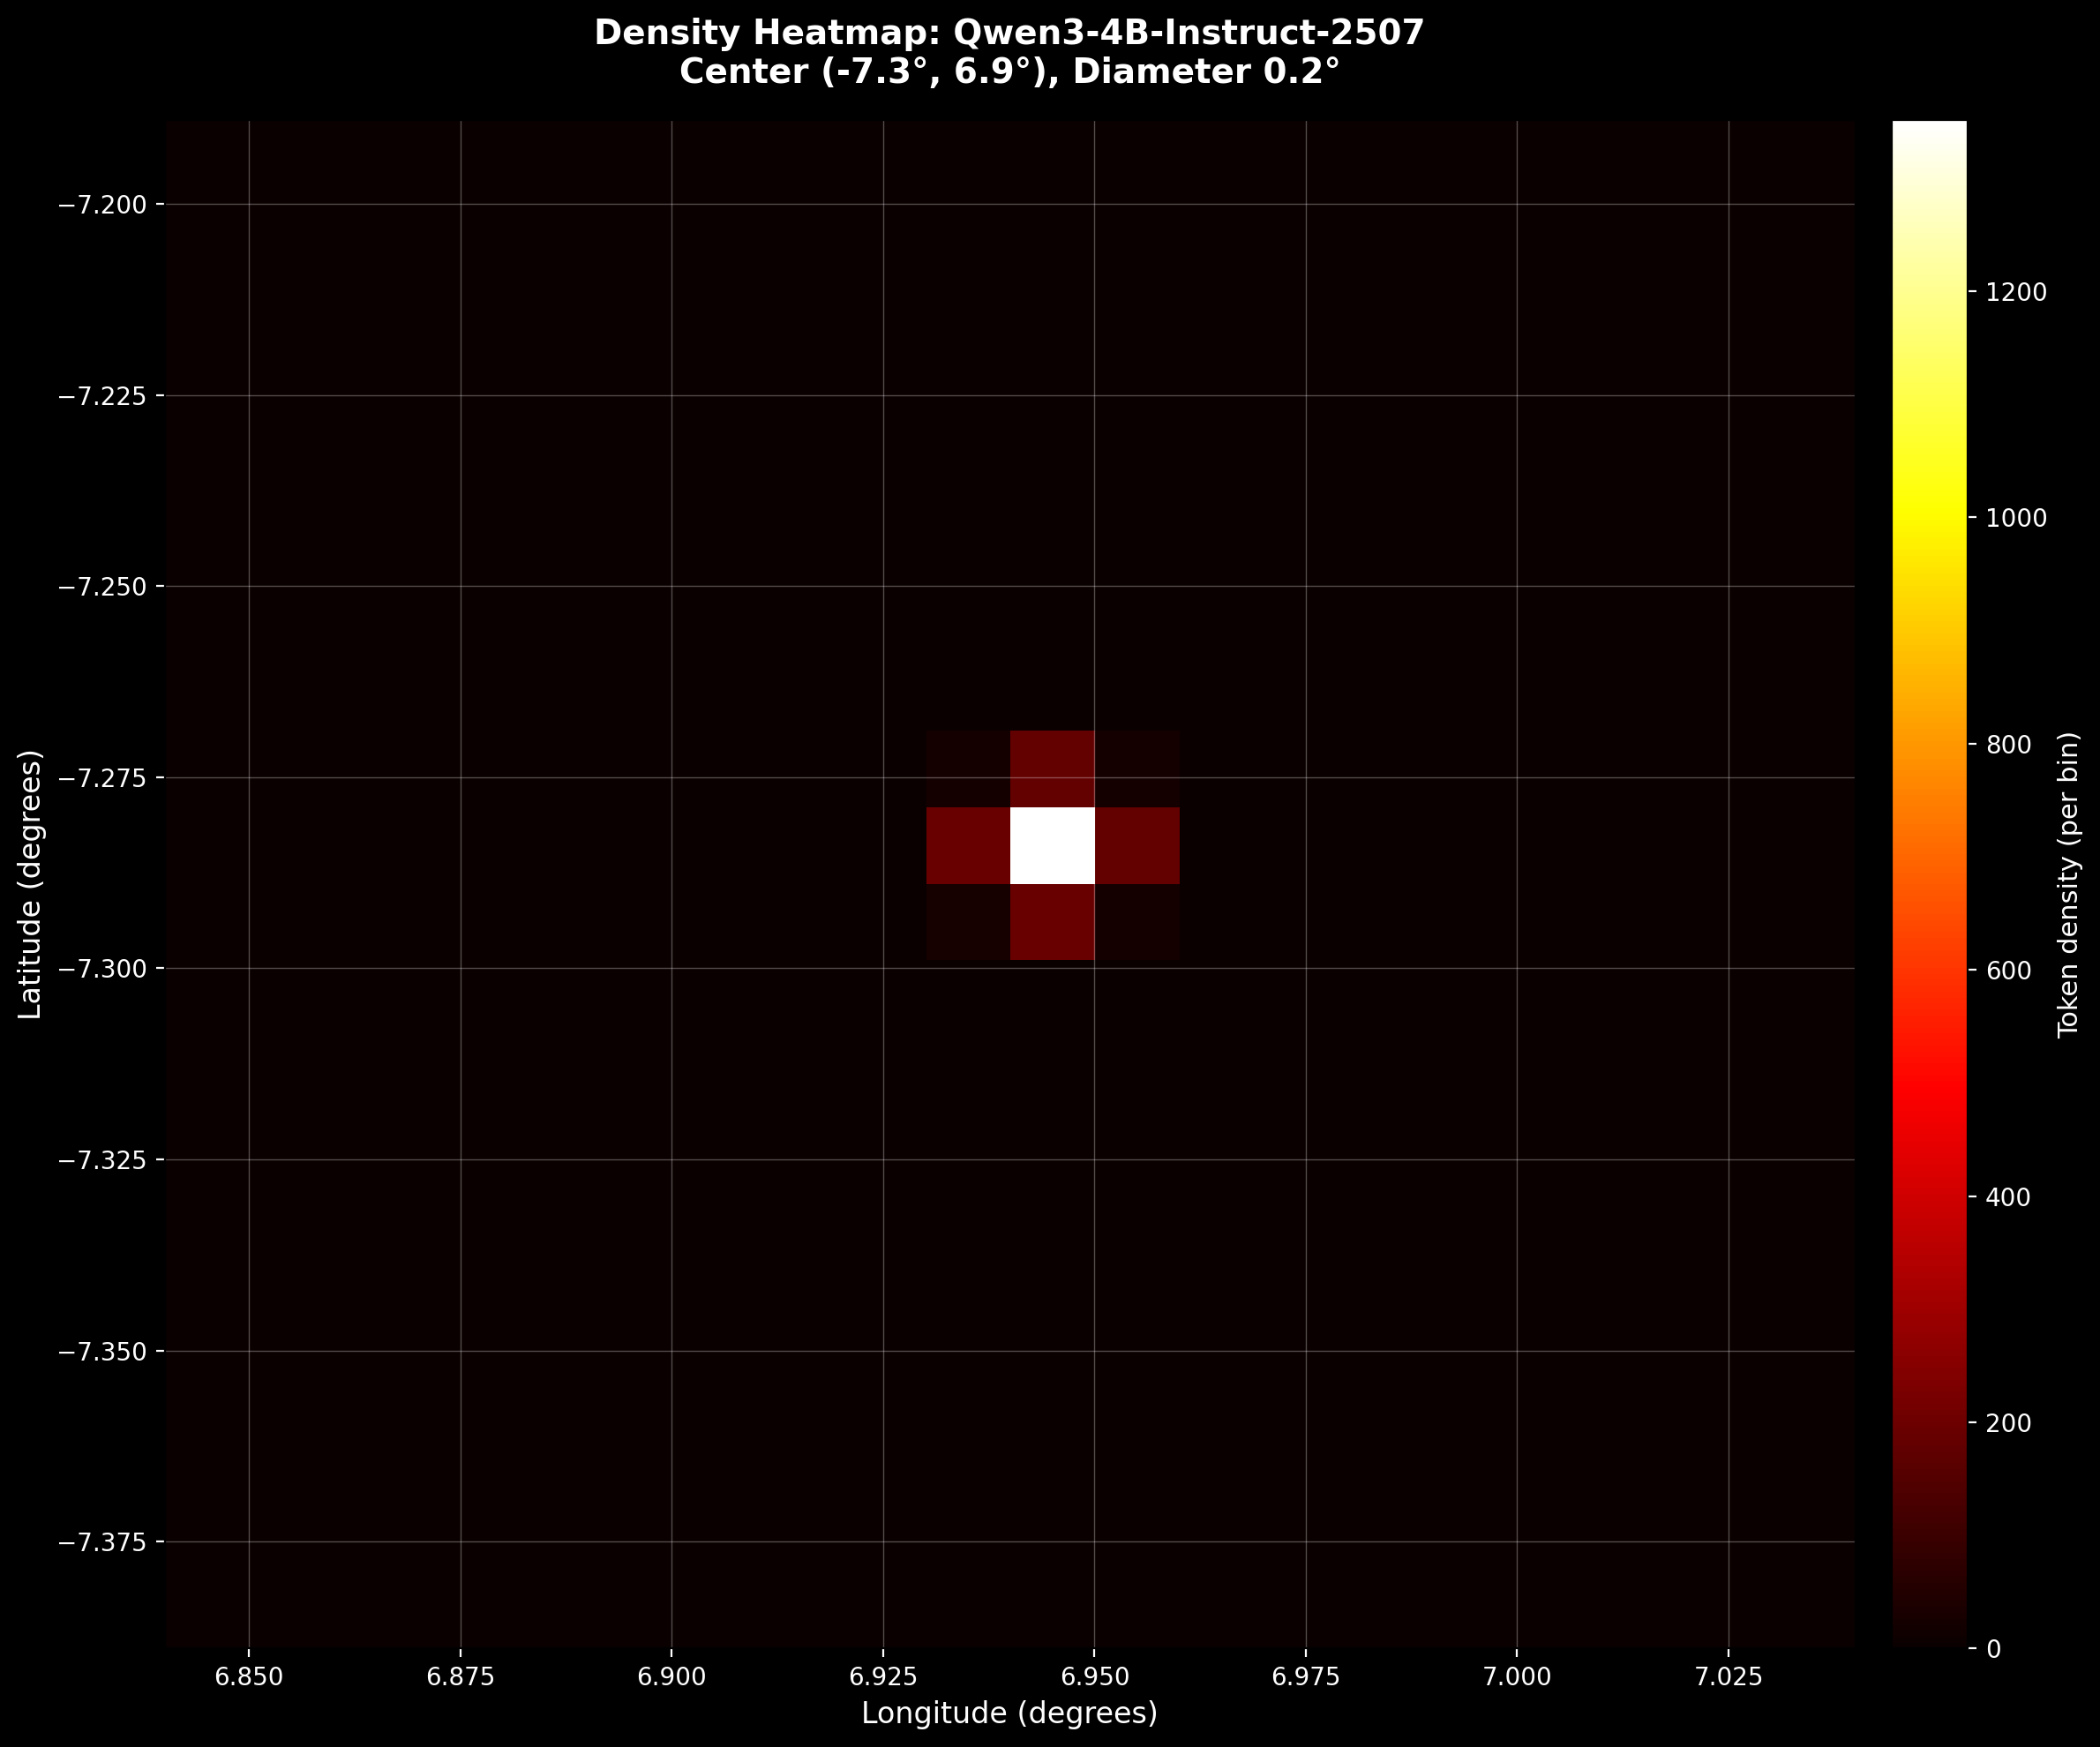

✓ Rectangular density heatmap complete


In [40]:
print("\nCreating rectangular density heatmap...\n")

# Compute bin counts
n_lon_bins = int(np.ceil(ANGULAR_DIAMETER / ANGULAR_BIN_SIZE))
n_lat_bins = int(np.ceil(ANGULAR_DIAMETER / ANGULAR_BIN_SIZE))

print(f"Density grid: {n_lon_bins} × {n_lat_bins} bins")
print(f"  Angular bin size: {ANGULAR_BIN_SIZE}°")
print()

# Create 2D histogram
hist, lon_edges, lat_edges = np.histogram2d(
    lon_plot, lat_plot,
    bins=[n_lon_bins, n_lat_bins],
    range=[[lon_min, lon_max], [lat_min, lat_max]]
)

# Apply Gaussian smoothing if requested
if DENSITY_SMOOTH is not None:
    hist = gaussian_filter(hist, sigma=DENSITY_SMOOTH)
    print(f"Applied Gaussian smoothing (σ = {DENSITY_SMOOTH})")

print(f"Density statistics:")
print(f"  Max density: {hist.max():.1f} tokens per bin")
print(f"  Mean density: {hist.mean():.1f} tokens per bin")
print()

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Plot heatmap
extent = [lon_min, lon_max, lat_min, lat_max]
im = ax.imshow(hist.T, origin='lower', extent=extent,
               cmap=DENSITY_COLORMAP, aspect='auto',
               interpolation='nearest', rasterized=True)

# Colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.02, fraction=0.046)
cbar.set_label('Token density (per bin)', color='white', fontsize=11)
cbar.ax.tick_params(colors='white')

# Formatting
ax.set_xlabel('Longitude (degrees)', color='white', fontsize=12)
ax.set_ylabel('Latitude (degrees)', color='white', fontsize=12)
ax.set_title(f'Density Heatmap: {MODEL_NAME}\nCenter ({CENTER_LAT:.1f}°, {CENTER_LON:.1f}°), Diameter {ANGULAR_DIAMETER:.1f}°',
             color='white', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, color='white', linewidth=0.5)
ax.tick_params(colors='white')

plt.tight_layout()
plt.show()

print("✓ Rectangular density heatmap complete")

## Observations

At this angular scale, look for:
- **Individual tokens**: Can we resolve discrete points?
- **Clustering**: Do tokens form tight groups?
- **Quantization effects**: Does the float32 vs bfloat16 comparison show discrete jumps in angular separation?
- **Empty regions**: Are there voids even at small scales?

Try zooming in further (smaller `ANGULAR_DIAMETER`) or changing the center coordinates to explore different regions.